# Proof of concept 

This is a proof of concept for the inclusion of positional uncertainty within the dwell time optimisation algorthim. The focus is on the optimisation method, and as such it is assumed that each seed radially deposits its energy purely based upon the inverse square law.

Two regions are defined, a central target region and a off centre avoid region.

## Initialisation

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
%matplotlib inline

from scipy.stats import norm

from utilities import BasinhoppingWrapper, create_green_cm

In [2]:
green_cm = create_green_cm()

Create the calculation grid

In [3]:
grid_spacing = 0.1

x_ = np.arange(-0.6, 0.6 + grid_spacing, grid_spacing)
y_ = np.arange(-0.6, 0.6 + grid_spacing, grid_spacing)
z_ = np.arange(-0.6, 0.6 + grid_spacing, grid_spacing)

x, y, z = np.meshgrid(x_, y_, z_)
x = np.ravel(x)
y = np.ravel(y)
z = np.ravel(z)

Define the target and avoid cubes

In [4]:
def target(x, y, z):
    return (
        (x < 0.45) & (x > -0.45) & 
        (y < 0.45) & (y > -0.45) & 
        (z < 0.45) & (z > -0.45))

def avoid(x, y, z):
    return (
        (x < 0.25) & (x > 0.05) & 
        (y < 0.15) & (y > -0.15) & 
        (z < 2) & (z > -2))

target_cube = target(x, y, z)

avoid_cube = avoid(x, y, z)

target_cube = target_cube & ~avoid_cube

Display the target and avoid cubes

(-0.59999999999999998, 0.59999999999999976)

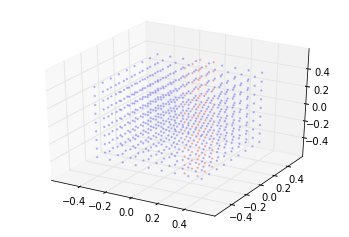

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')

ax.set_xlim([np.min(x_), np.max(x_)])
ax.set_ylim([np.min(y_), np.max(y_)])
ax.set_zlim([np.min(z_), np.max(z_)])

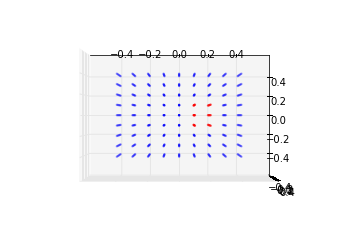

In [6]:
ax.view_init(azim=-90, elev=90)
fig

Create initial equidistant parrallel lines to represent catheters. Inbuild a slight random skew to emulate what occurs physically

In [7]:
lines_in_row = 4
spacing = np.linspace(-0.45, 0.45, lines_in_row)
number_of_lines = lines_in_row**2
wonkiness = 0.01

line_start = np.meshgrid(spacing, spacing, 1)

line_finish = np.array([
    line_start[0] + np.random.normal(scale=wonkiness, size=[lines_in_row, lines_in_row, 1]),
    line_start[1] + np.random.normal(scale=wonkiness, size=[lines_in_row, lines_in_row, 1]),
    -line_start[2]])

In [8]:
line_start = np.array([np.ravel(mesh) for mesh in line_start])
line_finish = np.array([np.ravel(mesh) for mesh in line_finish])

Display the lines overlayed

(-1, 1)

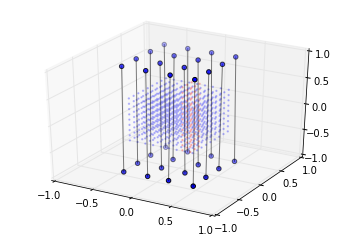

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')
ax.scatter(*line_start)
ax.scatter(*line_finish)

for i in range(len(line_start[0])):
    plt_coords = [
        [line_start[j][i], line_finish[j][i]]
        for j in range(len(line_start))]
    ax.plot(*plt_coords, color='black', alpha=0.5)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Create a function to return x, y, z coords when a distance along a line is requested

In [10]:
diff = (line_finish - line_start)
line_length = np.sqrt(diff[0]**2 + diff[1]**2 + diff[2]**2)

def find_distance_coords(line_num=None, distance=None):
    relative_dist = distance / line_length[line_num]
    
    if (relative_dist > 1) | (relative_dist < 0):
        return np.array([np.nan]*3)
    
    x = (
        line_start[0][line_num] * (1 - relative_dist) + 
        line_finish[0][line_num] * relative_dist)
    
    y = (
        line_start[1][line_num] * (1 - relative_dist) + 
        line_finish[1][line_num] * relative_dist)
        
    z = (
        line_start[2][line_num] * (1 - relative_dist) + 
        line_finish[2][line_num] * relative_dist)
    
    coords = np.array([x, y, z])
    
    return coords

Pick dwell positons starting at a random position along the line

In [11]:
dwell_spacing = 0.1 # Was 0.1, increased to 0.3 for testing
dwell_distances_from_initial = np.arange(0, 2, dwell_spacing)
number_of_dwells = len(dwell_distances_from_initial)

In [12]:
inital_dwell_position = np.random.uniform(
    low=0, high=dwell_spacing, size=number_of_lines)
inital_dwell_position

array([ 0.06264069,  0.03596739,  0.00374106,  0.03497639,  0.00697393,
        0.09232635,  0.02107214,  0.02687118,  0.05458971,  0.09844144,
        0.02774216,  0.09532883,  0.07396407,  0.04736313,  0.03194404,
        0.00807181])

In [13]:
dwell_distances = np.reshape(inital_dwell_position, (-1, 1)) + np.reshape(dwell_distances_from_initial, (1, -1))

In [14]:
def find_dwell_coords(line_num=None, dwell_num=None):
    distance = dwell_distances[line_num, dwell_num]
    
    coords = find_distance_coords(
        line_num=line_num, distance=distance)
    
    return coords

Find all the dwell positions that are on the grid

In [15]:
dwell_positions = np.array([
    [
        find_dwell_coords(
            line_num=line_num, dwell_num=dwell_num)
        for dwell_num in range(number_of_dwells)]
 for line_num in range(number_of_lines)])

Plot the dwell positions

In [16]:
line_colours = np.random.uniform(size=(number_of_lines,3))

(-1, 1)

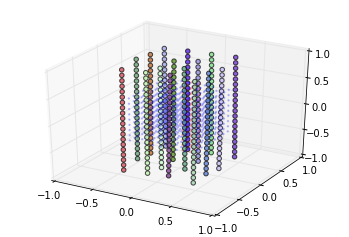

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')

for line_num in range(number_of_lines):
    ax.scatter(*np.transpose(dwell_positions[line_num]), 
               c=line_colours[line_num], alpha=0.7)


ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

Select the dwell positions that fall withing the target region. Only use these dwell positions.

In [18]:
dwell_positions_to_be_filtered = np.reshape(dwell_positions, (-1, 3))

distance_to_dwell_pos_initial = np.array([
    np.sqrt(
        (x[i] - dwell_positions_to_be_filtered[:,0])**2 + 
        (y[i] - dwell_positions_to_be_filtered[:,1])**2 + 
        (z[i] - dwell_positions_to_be_filtered[:,2])**2
    )
    for i in range(len(x))
])

In [19]:
# closest_voxel_to_dwell = np.reshape(np.argmin(distance_to_dwell_pos_initial, axis=0), [1, -1])
# target_cube_voxels = np.reshape(np.where(target_cube)[0], [-1, 1])
# is_dwell_closest_to_target = np.any(closest_voxel_to_dwell == target_cube_voxels, axis=0)

shift_uncertainty = 0.05

target_cube_voxels = np.where(target_cube)[0]
relevant_dwell_test = (
    np.min(distance_to_dwell_pos_initial[target_cube_voxels], axis=0) < 
    3 * shift_uncertainty)

In [20]:
relevant_dwell_positions = dwell_positions_to_be_filtered[relevant_dwell_test]
num_relevant_dwells = np.sum(relevant_dwell_test)

In [21]:
line_number_index = np.reshape(np.arange(number_of_lines), (number_of_lines, 1))
line_number_index = np.ones([number_of_lines, number_of_dwells]) * line_number_index
line_number_index = np.ravel(line_number_index)[relevant_dwell_test]
line_number_index = line_number_index.astype(int)

(-0.59999999999999998, 0.59999999999999976)

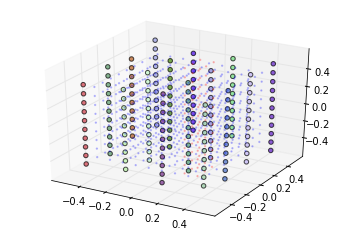

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')

ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')

for line_num in range(number_of_lines):
    ref = line_number_index == line_num
    ax.scatter(*np.transpose(relevant_dwell_positions[ref]), 
               c=line_colours[line_num], alpha=0.7)

ax.set_xlim([np.min(x_), np.max(x_)])
ax.set_ylim([np.min(y_), np.max(y_)])
ax.set_zlim([np.min(z_), np.max(z_)])



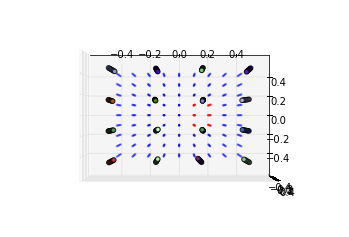

In [23]:
ax.view_init(azim=-90, elev=90)
fig

### Calculate distance between each dwell and each grid point

Create an array containing the distance to each dwell position for each voxel and translate this to exposure at that voxel per unit dwell time at each dwell position. This is defined in this way so that a reasonable portion of the calculation of exposure can be done outside of the optimisation.

In [24]:
distance_to_dwell_pos = np.array([
    np.sqrt(
        (x[i] - relevant_dwell_positions[:,0])**2 + 
        (y[i] - relevant_dwell_positions[:,1])**2 + 
        (z[i] - relevant_dwell_positions[:,2])**2
    )
    for i in range(len(x))
])

exposure_per_unit_time = 1 / distance_to_dwell_pos**2

### Estimate uncertainty in distance

Estimate the uncertainty in distance given a shift along the catheter

In [25]:
relevant_dwell_distances = np.ravel(dwell_distances)[relevant_dwell_test]

shifted_up = np.array([
    find_distance_coords(
        distance=relevant_dwell_distances[i] + shift_uncertainty, 
        line_num=line_number_index[i])
    for i in range(len(relevant_dwell_distances))
])

shifted_down = np.array([
    find_distance_coords(
        distance=relevant_dwell_distances[i] - shift_uncertainty, 
        line_num=line_number_index[i])
    for i in range(len(relevant_dwell_distances))
])

In [26]:
distance_to_dwell_shift_up = np.array([
    np.sqrt(
        (x[i] - shifted_up[:,0])**2 + 
        (y[i] - shifted_up[:,1])**2 + 
        (z[i] - shifted_up[:,2])**2
    )
    for i in range(len(x))
])

distance_to_dwell_shift_down = np.array([
    np.sqrt(
        (x[i] - shifted_down[:,0])**2 + 
        (y[i] - shifted_down[:,1])**2 + 
        (z[i] - shifted_down[:,2])**2
    )
    for i in range(len(x))
])

In [27]:
dwell_distance_uncertainty = (
    np.abs(distance_to_dwell_shift_up - distance_to_dwell_pos) + 
    np.abs(distance_to_dwell_shift_down - distance_to_dwell_pos)
) / 2

In [28]:
exposure_per_unit_time_uncertainty = np.abs(-2 / distance_to_dwell_pos ** 3) * dwell_distance_uncertainty

Create exposure calculation function

In [29]:
def calculate_exposure(dwell_times, with_uncertainty=False):
    exposure = np.sum(dwell_times * exposure_per_unit_time, axis=1)
    
    if with_uncertainty:
        exposure_uncertainty = np.sqrt(np.sum((dwell_times * exposure_per_unit_time_uncertainty)**2, axis=1))
    
        return exposure, exposure_uncertainty
    
    else:
        return exposure

Test probability of cold spot

In [30]:
def probability_of_cold_spot(exposure, exposure_uncertainty, cut_off):
    return 1 - (1 - norm.cdf(
            np.ones_like(exposure)*cut_off, 
            loc=exposure, 
            scale=exposure_uncertainty
        )).prod()

In [31]:
dwell_test = np.ones(num_relevant_dwells) * 0.2
exposure, exposure_uncertainty = calculate_exposure(dwell_test, with_uncertainty=True)

cold_spot_magnitude = 40
cold_test = np.ones_like(exposure[target_cube]) * cold_spot_magnitude
test_ref = (
    (1 - norm.cdf(
            cold_test, loc=exposure[target_cube], 
            scale=exposure_uncertainty[target_cube])
    ) < 0.999)

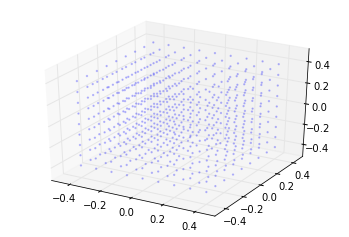

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')

ax.scatter(
    x[target_cube][test_ref], y[target_cube][test_ref], z[target_cube][test_ref], 
    alpha=0.7, s=20, color='red')

Run a test of arbitrary dwell times

In [33]:
num_relevant_dwells = len(relevant_dwell_positions)

random_pick = np.random.uniform(
    size=2, high=num_relevant_dwells, low=0).astype(int)

dwell_times = np.zeros([1, num_relevant_dwells])
dwell_times[0, random_pick] = 10

exposure = calculate_exposure(dwell_times)

(-0.59999999999999998, 0.59999999999999976)

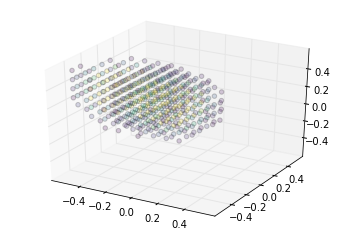

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

reference = exposure > 80
colour = exposure[reference]
colour[colour > 200] = 200

ax.scatter(
    x[reference], y[reference], z[reference], 
    alpha=0.2, s=20, c=colour, cmap=green_cm)


ax.set_xlim([np.min(x_), np.max(x_)])
ax.set_ylim([np.min(y_), np.max(y_)])
ax.set_zlim([np.min(z_), np.max(z_)])

### Create the optimisation cost function

The maximum exposure to a grid position not within the target is aimed to be less than 100. This cost function aims to achieve this.

(0, 20)

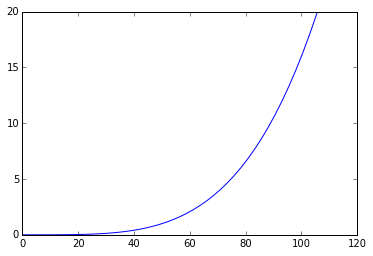

In [35]:
def hot_exterior_cost_function(max_target_exterior):
    return ((max_target_exterior)/50)**4

testx = np.linspace(0, 120)
testy = hot_exterior_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

No grid point within the target is to be less than about 50. This cost function aims to achieve this.

(0, 20)

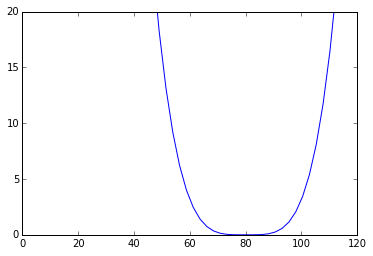

In [36]:
def cold_target_cost_function(min_target):
    return ((min_target-80)/15)**4

testx = np.linspace(0, 120)
testy = cold_target_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

The avoid cost function aims to make no point within the avoid structure more than 45.

(0, 20)

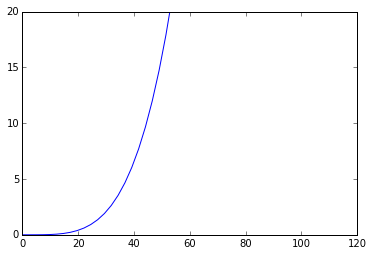

In [37]:
def hot_avoid_cost_function(max_avoid):
    return ((max_avoid)/25)**4

testx = np.linspace(0, 120)
testy = hot_avoid_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

Create the cost function to be used by the optimiser

In [59]:
cold_spot_magnitude = 40
cold_cost_multiplier = 20 / 0.05 # 20 / 0.003


def cost_function(dwell_times, debug=False):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure, exposure_uncertainty = calculate_exposure(
        dwell_times, with_uncertainty=True)

    min_target = np.min(exposure[target_cube])
    max_avoid = np.max(exposure[avoid_cube])
    max_target_exterior = np.max(exposure[~target_cube])
    cold_prob = probability_of_cold_spot(
        exposure[target_cube], 
        exposure_uncertainty[target_cube],
        cold_spot_magnitude)
    
    cold_prob_cost = cold_cost_multiplier * cold_prob
    cold_target_cost = cold_target_cost_function(min_target)
    hot_exterior_cost = hot_exterior_cost_function(max_target_exterior)
    hot_avoid_cost = hot_avoid_cost_function(max_avoid)
    
    total_cost = (
        hot_exterior_cost + cold_target_cost + 
        hot_avoid_cost + cold_prob_cost)
    
    if debug:
        print("Cold probability = %0.4f, resulting cost = %0.4f" %
              (cold_prob, cold_prob_cost))
        print("Minimum target = %0.4f, resulting cost = %0.4f" %
              (min_target, cold_target_cost))
        print("Maximum exterior = %0.4f, resulting cost = %0.4f" %
              (max_target_exterior, hot_exterior_cost))
        print("Maximum avoid = %0.4f, resulting cost = %0.4f" %
              (max_avoid, hot_avoid_cost))
        print("Total cost = %0.4f" % (total_cost))
        
    
    return total_cost

Create function to display the results of the optimisation as it is being calculated.

In [60]:
def display_results(dwell_times):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    reference = exposure > 25
    colour = exposure[reference]
    colour[colour > 100] = 100
    
    small = exposure[reference] < 50
    large = ~small

    ax.scatter(
        x[reference][small], y[reference][small], z[reference][small], 
        alpha=0.2, s=3, c=colour[small], cmap=green_cm)
    
    ax.scatter(
        x[reference][large], y[reference][large], z[reference][large], 
        alpha=0.4, s=20, c=colour[large], cmap=green_cm)


    ax.set_xlim([np.min(x_), np.max(x_)])
    ax.set_ylim([np.min(y_), np.max(y_)])
    ax.set_zlim([np.min(z_), np.max(z_)])
    
    cost_function(dwell_times, debug=True)
    
    plt.show()

Create initial conditions

In [61]:
num_relevant_dwells

170

In [62]:
initial_conditions = np.ones(num_relevant_dwells)*0.1

Step noise

In [63]:
step_noise = np.ones(num_relevant_dwells) * 0.3

Bounds

In [64]:
bounds = ((0, None),)*num_relevant_dwells

Run the optimiser

Cold probability = 0.0461, resulting cost = 18.4264
Minimum target = 57.7807, resulting cost = 4.8145
Maximum exterior = 98.4437, resulting cost = 15.0270
Maximum avoid = 60.1717, resulting cost = 33.5591
Total cost = 71.8271


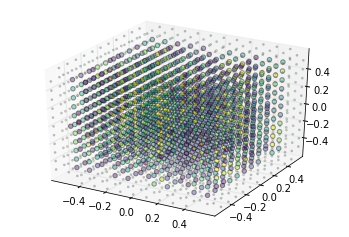

Cold probability = 0.0452, resulting cost = 18.0916
Minimum target = 56.5299, resulting cost = 5.9937
Maximum exterior = 99.3922, resulting cost = 15.6145
Maximum avoid = 59.7712, resulting cost = 32.6744
Total cost = 72.3743


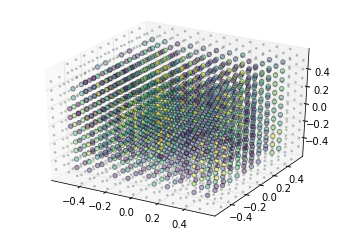

Cold probability = 0.0391, resulting cost = 15.6221
Minimum target = 58.8600, resulting cost = 3.9450
Maximum exterior = 101.2755, resulting cost = 16.8321
Maximum avoid = 61.2964, resulting cost = 36.1393
Total cost = 72.5385


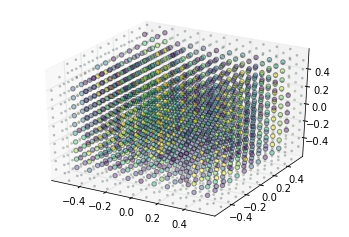

Cold probability = 0.0448, resulting cost = 17.9396
Minimum target = 57.3943, resulting cost = 5.1583
Maximum exterior = 100.8486, resulting cost = 16.5501
Maximum avoid = 60.8514, resulting cost = 35.1012
Total cost = 74.7491


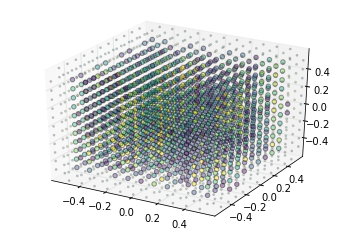

Cold probability = 0.0436, resulting cost = 17.4468
Minimum target = 57.6457, resulting cost = 4.9327
Maximum exterior = 101.7163, resulting cost = 17.1271
Maximum avoid = 60.6782, resulting cost = 34.7033
Total cost = 74.2098


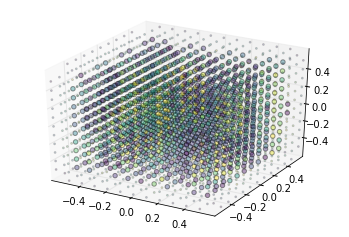

In [65]:
optimisation = BasinhoppingWrapper(
    to_minimise=cost_function,
    initial=initial_conditions,
    step_noise=step_noise,
    basinhopping_confidence=5,
    optimiser_confidence=0.0001,
    n=5,
    debug=display_results,
    bounds=bounds
)

## Presentation of results

Cold probability = 0.0351, resulting cost = 14.0585
Minimum target = 55.7326, resulting cost = 6.8506
Maximum exterior = 97.7026, resulting cost = 14.5796
Maximum avoid = 60.9759, resulting cost = 35.3893
Total cost = 70.8780


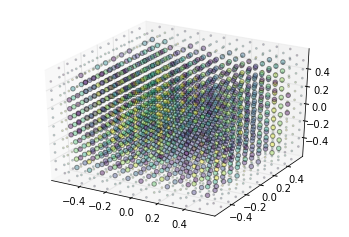

In [66]:
display_results(optimisation.result)

Display histogram of resulting dwell times

(array([ 15.,   3.,   7.,   5.,  16.,  26.,  54.,  30.,   9.,   5.]),
 array([ 0.        ,  0.0190893 ,  0.03817861,  0.05726791,  0.07635722,
         0.09544652,  0.11453582,  0.13362513,  0.15271443,  0.17180374,
         0.19089304]),
 <a list of 10 Patch objects>)

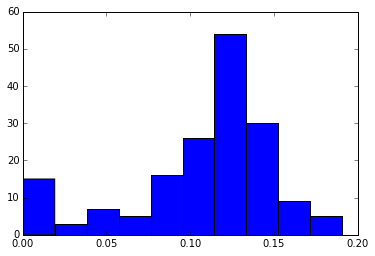

In [67]:
plt.hist(optimisation.result)

Give overview of dwell times segmented by catheter

Line number 0


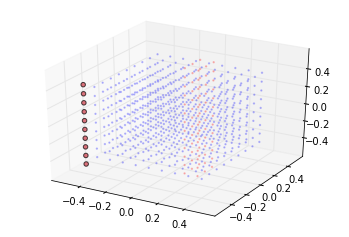

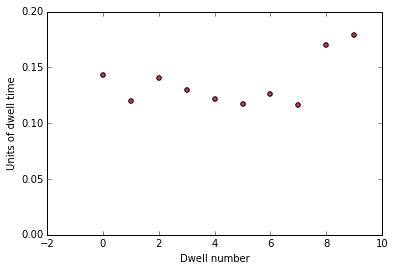

Line number 1


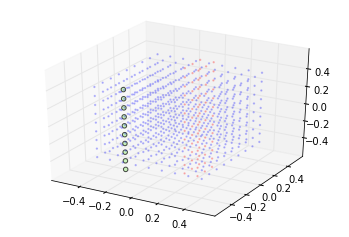

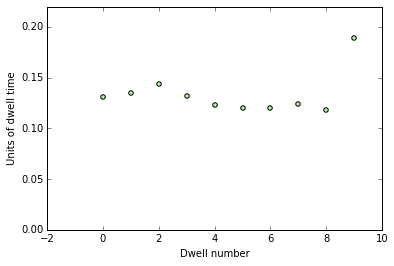

Line number 2


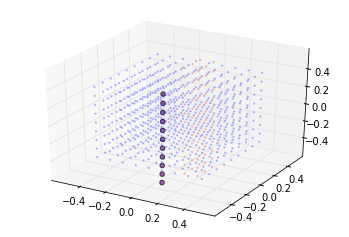

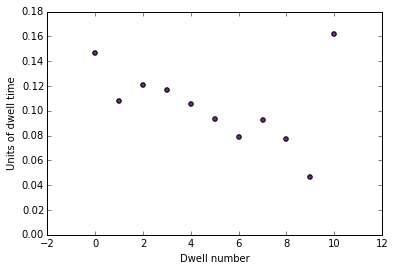

Line number 3


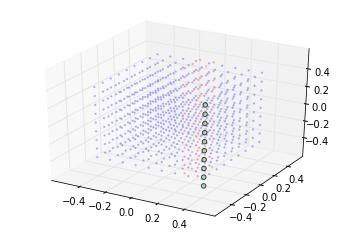

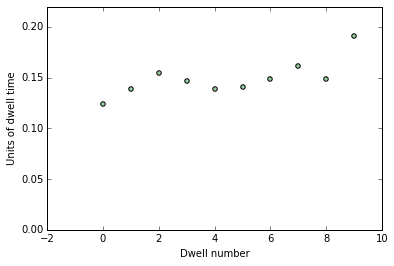

Line number 4


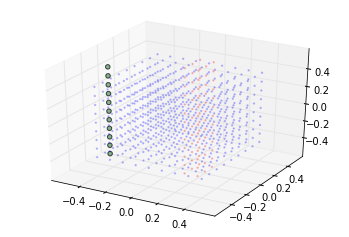

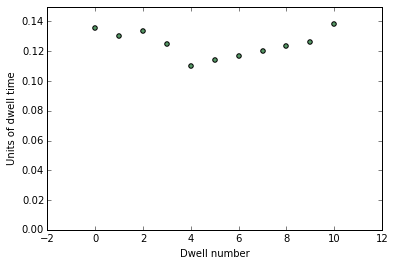

Line number 5


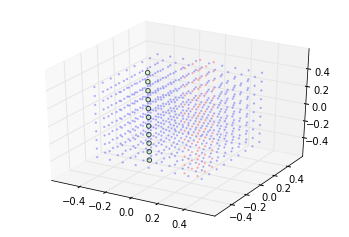

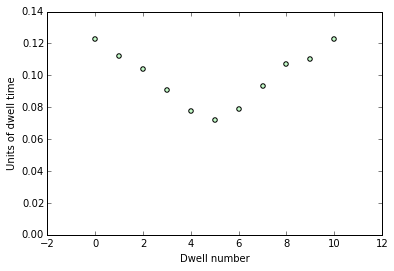

Line number 6


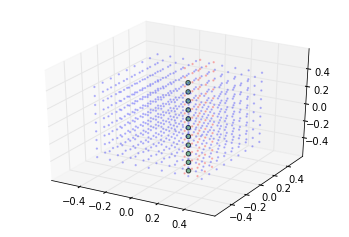

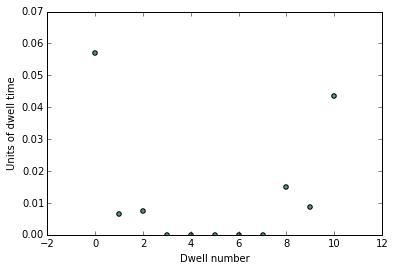

Line number 7


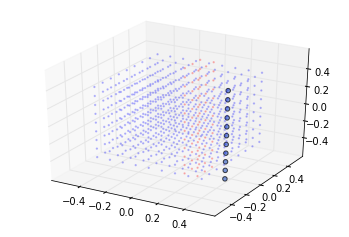

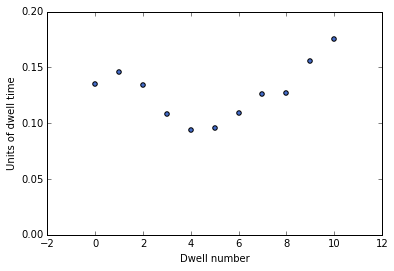

Line number 8


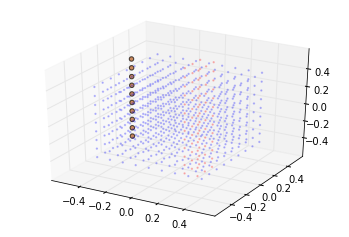

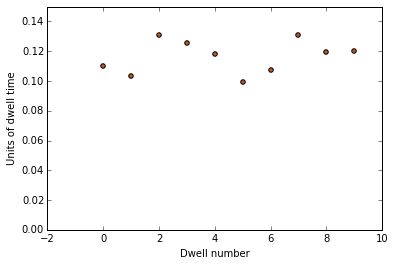

Line number 9


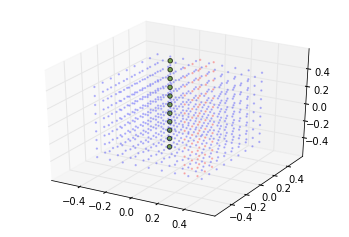

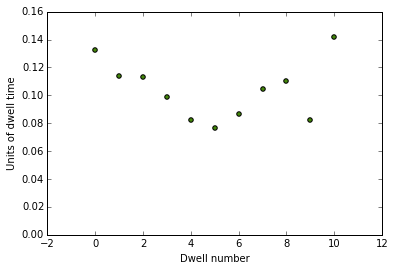

Line number 10


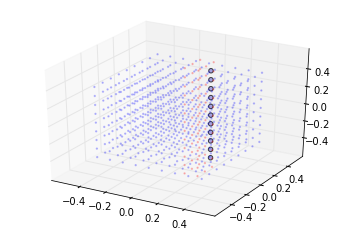

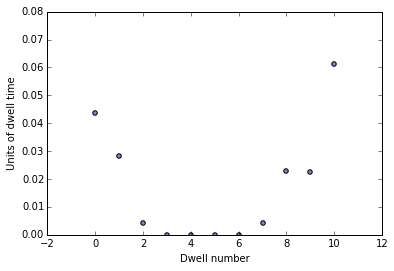

Line number 11


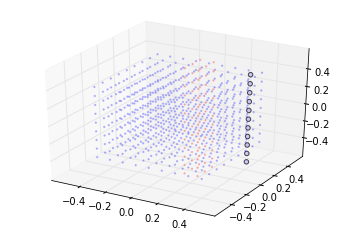

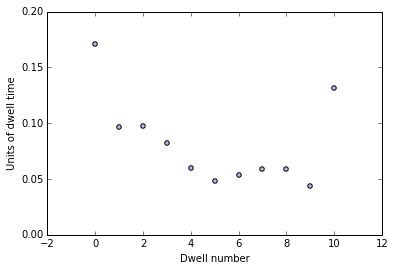

Line number 12


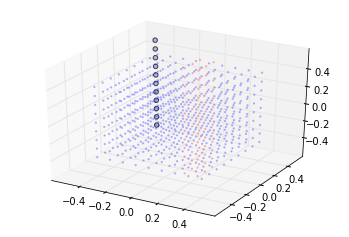

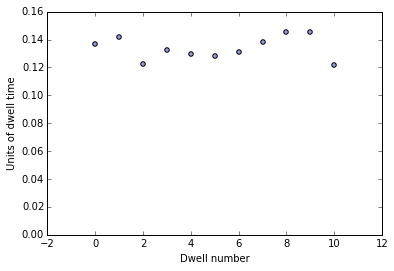

Line number 13


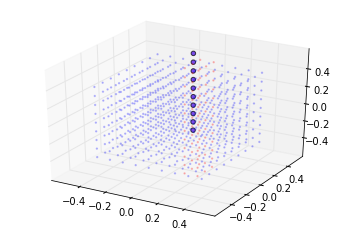

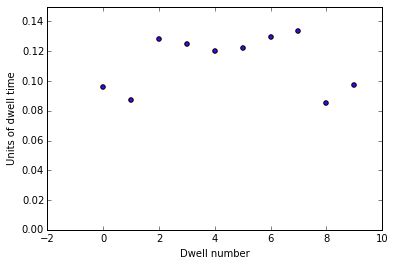

Line number 14


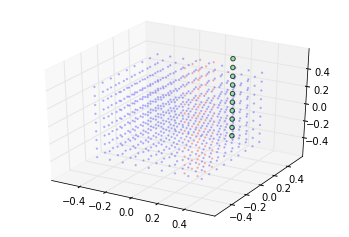

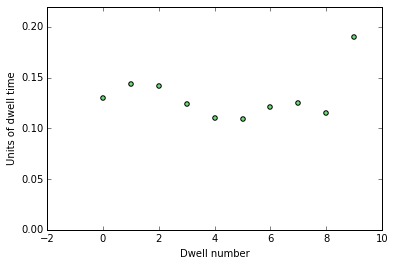

Line number 15


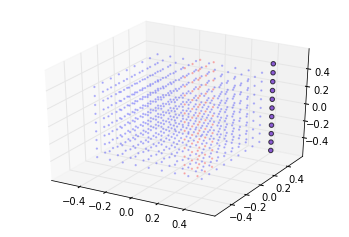

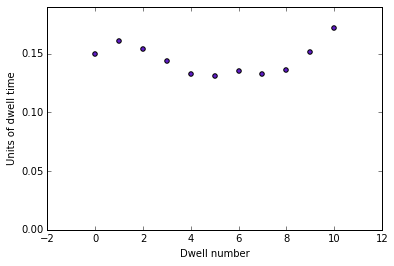

In [68]:
for line_num in range(number_of_lines):
    
    print("Line number %d" % (line_num))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        x[target_cube], y[target_cube], z[target_cube], 
        alpha=0.2, s=2, color='blue')
    ax.scatter(
        x[avoid_cube], y[avoid_cube], z[avoid_cube], 
        alpha=0.2, s=2, color='red')
    
    ref = line_number_index == line_num
    ax.scatter(*np.transpose(relevant_dwell_positions[ref]), 
               c=line_colours[line_num], alpha=0.7)


    ax.set_xlim([np.min(x_), np.max(x_)])
    ax.set_ylim([np.min(y_), np.max(y_)])
    ax.set_zlim([np.min(z_), np.max(z_)])
    
    plt.show() 
    
    
    plt.scatter(np.arange(np.sum(ref)), optimisation.result[ref],
               c=line_colours[line_num])
    plt.xlabel("Dwell number")
    plt.ylabel("Units of dwell time")
    
    plt.ylim(bottom=0)
    plt.show()

Convert result into column vector for post analysis

In [69]:
dwell_times = np.reshape(optimisation.result, (1, num_relevant_dwells))

Create a custom resolution exposure calculation function for post analysis

In [70]:
def create_calculate_exposure(dwell_positions, 
                              x_new=None, y_new=None, z_new=None):
    x, y, z = np.meshgrid(
        x_new, y_new, z_new)
    x = np.ravel(x)
    y = np.ravel(y)
    z = np.ravel(z)

    distance_to_dwell_pos = np.array([
        np.sqrt(
            (x[i] - dwell_positions[:,0])**2 + 
            (y[i] - dwell_positions[:,1])**2 + 
            (z[i] - dwell_positions[:,2])**2
        )
        for i in range(len(x))
    ])

    exposure_per_unit_time = 1 / distance_to_dwell_pos**2
    
    def calculate_exposure(dwell_times, reshape=False):
        exposure = np.sum(dwell_times * exposure_per_unit_time, axis=1)
        if reshape:
            exposure = np.reshape(exposure, (
                len(x_new), len(y_new), len(z_new)))
        return exposure
        
    return calculate_exposure

In [71]:
dx = 0.01; dy = 0.01; dz = 0.1

contour_x_ = np.arange(-1, 1 + dx, dx)
contour_y_ = np.arange(-1, 1 + dy, dy)
contour_z_ = z_ #np.arange(-0.7, 0.7 + dz, dz)

contour_calculate_exposure = create_calculate_exposure(
    relevant_dwell_positions, x_new=contour_x_, y_new=contour_y_, z_new=contour_z_)

contour_exposure_init = contour_calculate_exposure(dwell_times, reshape=True)

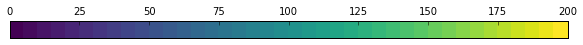

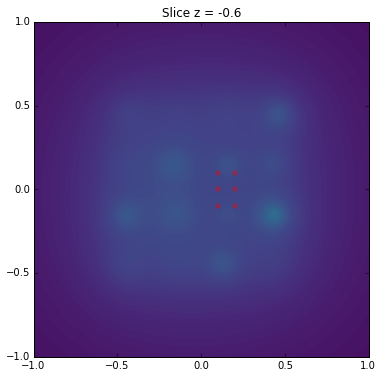

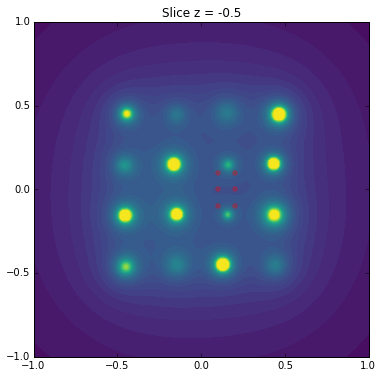

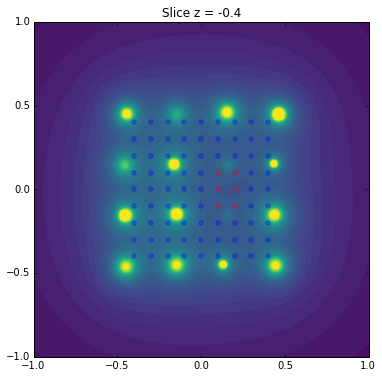

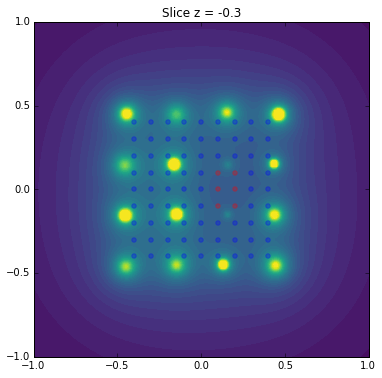

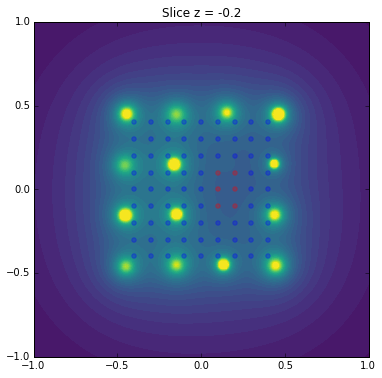

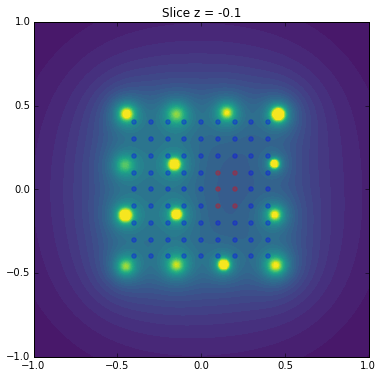

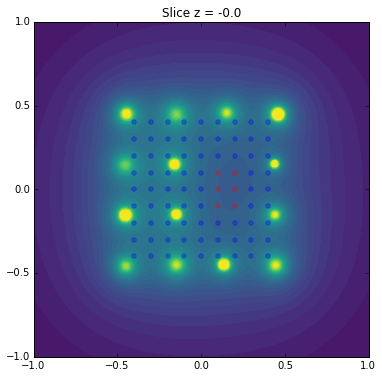

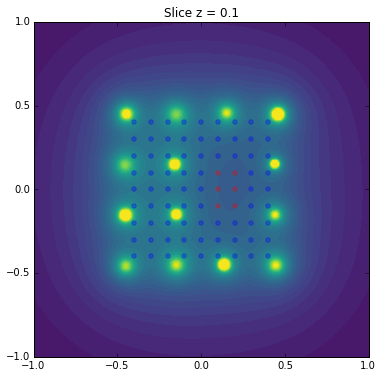

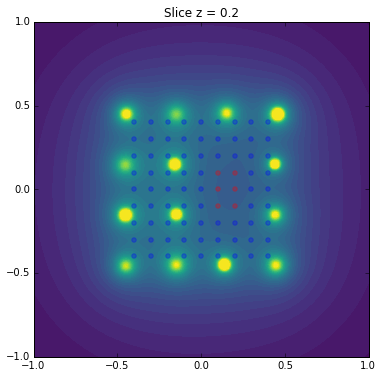

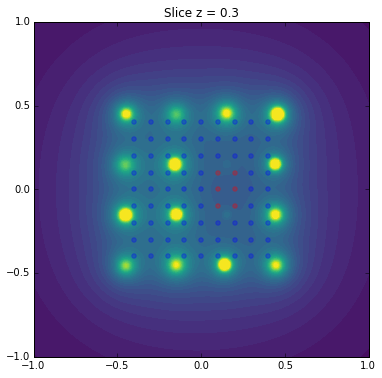

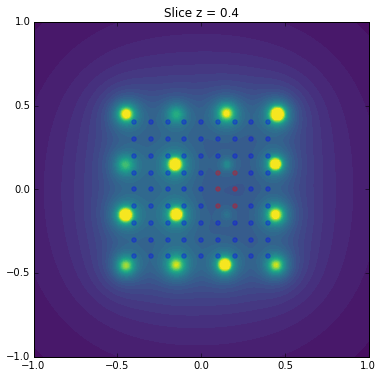

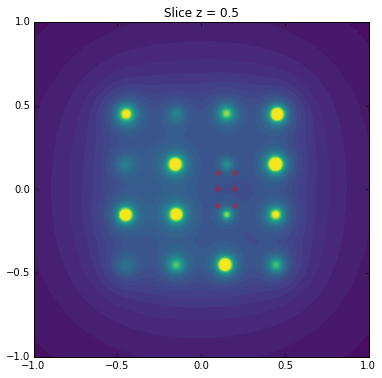

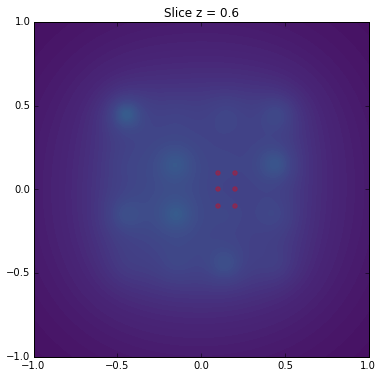

In [72]:
vmin = 0
vmax = 200
num_contours = 41

fig = plt.figure(figsize=(10,0.3))
cbar_ax = fig.add_subplot(1,1,1)

bounds = np.linspace(vmin, vmax, num_contours)
norm = BoundaryNorm(bounds, green_cm.N)


cb = ColorbarBase(
    cbar_ax, norm=norm, cmap=green_cm,
    orientation='horizontal')

cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

cb.set_clim([vmin, vmax])


contour_exposure = contour_exposure_init.copy()
contour_exposure[contour_exposure > vmax] = vmax


for i, z_value in enumerate(contour_z_):
    plt.figure(figsize=(6,6))
    
    c = plt.contourf(contour_x_, contour_y_,
        contour_exposure[:, :, i], num_contours,
        vmin=vmin, vmax=vmax, cmap=green_cm)
    
    reference = z[target_cube] == z_value
    x_target = x[target_cube][reference]
    y_target = y[target_cube][reference]
    plt.scatter(x_target, y_target, alpha=0.3, color='blue')
    
    reference = z[avoid_cube] == z_value
    x_avoid = x[avoid_cube][reference]
    y_avoid = y[avoid_cube][reference]
    plt.scatter(x_avoid, y_avoid, alpha=0.3, color='red')
    
    plt.title("Slice z = %0.1f" % (z_value))
    plt.xlim([np.min(contour_x_), np.max(contour_x_)])
    plt.ylim([np.min(contour_y_), np.max(contour_y_)])
    plt.show()

## Analysis of results

Create analysis grid

In [73]:
dx = 0.02
dy = 0.02
dz = 0.02

post_x_ = np.arange(-1, 1 + dx, dx)
post_y_ = np.arange(-1, 1 + dy, dy)
post_z_ = np.arange(-1, 1 + dz, dz)

post_x, post_y, post_z = np.meshgrid(
    post_x_, post_y_, post_z_)
post_x = np.ravel(post_x)
post_y = np.ravel(post_y)
post_z = np.ravel(post_z)

post_calculate_exposure = create_calculate_exposure(
    relevant_dwell_positions, x_new=post_x_, y_new=post_y_, z_new=post_z_)

post_exposure = post_calculate_exposure(dwell_times)

Define structures on new finer grid

In [74]:
post_target_cube = target(post_x, post_y, post_z)
post_avoid_cube = avoid(post_x, post_y, post_z)

Make a function to plot DVHs given a reference

In [75]:
def create_dvh(reference, exposure, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    
    results = exposure[reference]
    results[results>150] = 150
    hist = np.histogram(results, 100)
    
    freq = hist[0]
    bin_edge = hist[1]
    bin_mid = (bin_edge[1::] + bin_edge[:-1:])/2
    
    cumulative = np.cumsum(freq[::-1])
    cumulative = cumulative[::-1]
    bin_mid = np.append([0], bin_mid)
    
    cumulative = np.append(cumulative[0], cumulative)
    percent_cumulative = cumulative / cumulative[0] * 100

    ax.plot(bin_mid, percent_cumulative)

Plotting of relevant DVHs

(0, 150)

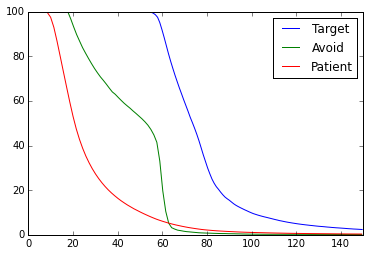

In [76]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_target_cube, post_exposure, ax=ax)
create_dvh(post_avoid_cube, post_exposure, ax=ax)
create_dvh(~post_target_cube, post_exposure, ax=ax)

plt.legend(["Target", "Avoid", "Patient"])

plt.xlim([0, 150])

Add a random shift to each catheter, see the effect it has on target DVH.

In [77]:
# shift_uncertainty = 0.05

In [78]:
line_displacement = np.random.normal(scale=shift_uncertainty, size=number_of_lines)

In [79]:
shifted_dwell_positions = np.array([
    find_distance_coords(
        distance=relevant_dwell_distances[i] + line_displacement[line_number_index[i]], 
        line_num=line_number_index[i])
    for i in range(len(relevant_dwell_distances))
])

In [80]:
shifted_calculate_exposure = create_calculate_exposure(
    shifted_dwell_positions, x_new=post_x_, y_new=post_y_, z_new=post_z_)

shifted_exposure = shifted_calculate_exposure(dwell_times)

With the shift the change in the DVH is the following. For the optimisation given here there is very little change in DVH.

(0, 110)

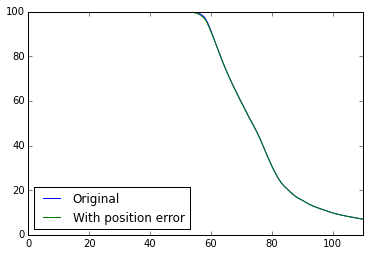

In [81]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_target_cube, post_exposure, ax=ax)
create_dvh(post_target_cube, shifted_exposure, ax=ax)

plt.legend(["Original", "With position error"], loc='lower left')

plt.xlim([0, 110])
# plt.ylim([95, 100])

In [82]:
np.min(shifted_exposure[post_target_cube])

50.920017770432899

In [83]:
np.min(post_exposure[post_target_cube])

52.494942673999873

(0, 110)

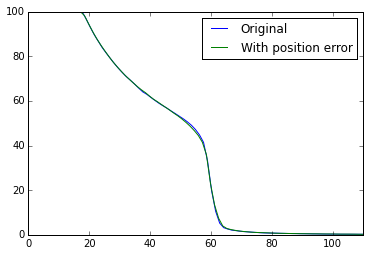

In [84]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_avoid_cube, post_exposure, ax=ax)
create_dvh(post_avoid_cube, shifted_exposure, ax=ax)

plt.legend(["Original", "With position error"], loc='upper right')

plt.xlim([0, 110])

## Overview of shift results

In [85]:
exposure = calculate_exposure(dwell_times)
np.min(exposure[target_cube])

55.732599322693204

In [86]:
def return_cold_spot_in_random_displace():
    line_displacement = np.random.normal(scale=shift_uncertainty, size=number_of_lines)

    shifted_dwell_positions = np.array([
        find_distance_coords(
            distance=relevant_dwell_distances[i] + line_displacement[line_number_index[i]], 
            line_num=line_number_index[i])
        for i in range(len(relevant_dwell_distances))
    ])

    shifted_calculate_exposure = create_calculate_exposure(
        shifted_dwell_positions, x_new=x_, y_new=y_, z_new=z_)

    shifted_exposure = shifted_calculate_exposure(dwell_times)

    return np.min(shifted_exposure[target_cube])

In [87]:
n = 10000
cold_spots = np.zeros(n)

for i in range(n):
    cold_spots[i] = return_cold_spot_in_random_displace()

(35, 60)

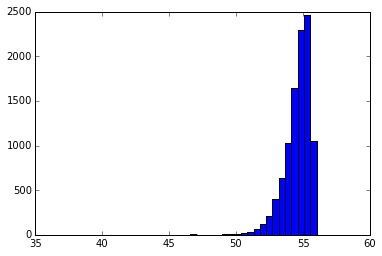

In [89]:
plt.hist(cold_spots,20)
plt.xlim([35,60])